In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# EDA

In [2]:
ccpH = pd.read_csv("credit_card_propensity_historical.csv")
print(ccpH.shape)
print(ccpH.isna().sum())

(245725, 11)
ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64


There is a moderate amount of missingness in Credit_Product. We can treat missing values as its own category. 

In [3]:
ccpH.fillna('Missing');

The vintage variable is right skewed so we go down Tukey's ladder.

Text(0.5, 1.0, 'Distribution of Vintage')

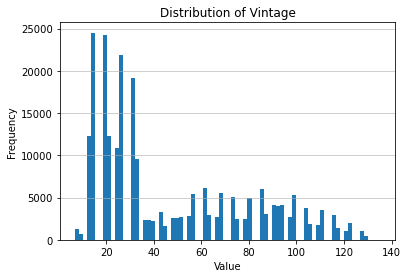

In [4]:
n, bins, patches = plt.hist(x=ccpH['Vintage'], bins='auto')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Vintage')

Text(0.5, 1.0, 'Distribution of Vintage')

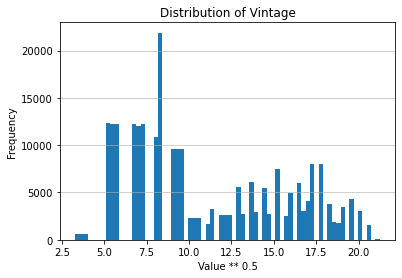

In [5]:
n, bins, patches = plt.hist(x=(ccpH['Vintage'] ** (1/2) - 1)/(1/2), bins='auto')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value ** 0.5')
plt.ylabel('Frequency')
plt.title('Distribution of Vintage')

Text(0.5, 1.0, 'Distribution of Vintage')

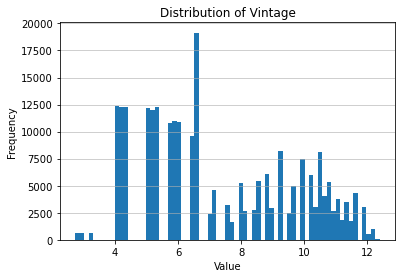

In [6]:
n, bins, patches = plt.hist(x=(ccpH['Vintage'] ** (1/3) - 1)/(1/3), bins='auto')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Vintage')

Text(0.5, 1.0, 'Distribution of Log Vintage')

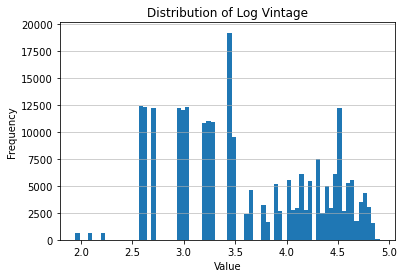

In [7]:
n, bins, patches = plt.hist(x=np.log(ccpH['Vintage']), bins='auto')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Log Vintage')

In [8]:
ccpH['Vintage']=np.log(ccpH['Vintage'])

In [9]:
ccpH_train, ccpH_test = train_test_split(ccpH, test_size=0.20, random_state=20764471)

We can One Hot Encode our categorical columns and scale the real columns.

In [10]:
enc = OneHotEncoder()
enc.fit(ccpH_train[['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']])
X_train_cat = enc.transform(ccpH_train[['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']]).toarray()
X_train_cat_df = pd.DataFrame(X_train_cat)
X_train_cat_df.columns = enc.get_feature_names()
scaler = MinMaxScaler()
scaler.fit(ccpH_train[['Age','Vintage','Avg_Account_Balance']])
X_train_real = scaler.transform(ccpH_train[['Age','Vintage','Avg_Account_Balance']])
X_train_real_df = pd.DataFrame(X_train_real)
X_train_real_df.columns = ['Age','Vintage','Avg_Account_Balance']
X_train = pd.concat([X_train_cat_df, X_train_real_df], axis=1)
y_train = ccpH_train[['Is_Lead']]

Next we transform the test set.

In [11]:
X_test_cat = enc.transform(ccpH_test[['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']]).toarray()
X_test_real = scaler.transform(ccpH_test[['Age','Vintage','Avg_Account_Balance']])
X_test = pd.DataFrame(np.concatenate((X_test_cat, X_test_real), axis=1))
X_test.columns = X_train.columns
y_test = ccpH_test[['Is_Lead']]

# Unadjusted Model Evaluation
We will look at the confusion matrix, accuracy, precision, and recall of the unadjusted model. Accuracy is similar between baseline and weighted models. Precision is higher for the baseline model but recall is higher for the weighted model. Other metrics that may be better for evaluating include F1 score, which considers both precision and recall, and AUC. 

In [12]:
ccpH_xgb = xgb.XGBClassifier(objective = "binary:logistic")
ccpH_xgb.fit(X_train,y_train)
y_pred = ccpH_xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("The accuracy of the baseline model is {}".format(ccpH_xgb.score(X_test,y_test)))
print("The precision of the baseline model is {}".format(precision_score(y_test, y_pred)))
print("The recall of the baseline model is {}".format(recall_score(y_test, y_pred)))

/Users/harry/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/harry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:52:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[35847  1709]
 [ 5164  6425]]
The accuracy of the baseline model is 0.8601485400345915
The precision of the baseline model is 0.7898942709613966
The recall of the baseline model is 0.5544050392613685


# Model Class Weights
We will set the scale_pos_weight parameter as the number of negative instances over the number of positive.

In [13]:
ccpH_xgb_weighted = xgb.XGBClassifier(objective = "binary:logistic",
                                      scale_pos_weight = (X_train.shape[0] - sum(y_train.Is_Lead)) / sum(y_train.Is_Lead))
ccpH_xgb_weighted.fit(X_train,y_train)
y_pred_weighted = ccpH_xgb_weighted.predict(X_test)
print(confusion_matrix(y_test, y_pred_weighted))
print("The accuracy of the weighted model is {}".format(ccpH_xgb_weighted.score(X_test,y_test)))
print("The precision of the weighted model is {}".format(precision_score(y_test, y_pred_weighted)))
print("The recall of the weighted model is {}".format(recall_score(y_test, y_pred_weighted)))

/Users/harry/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/harry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:52:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[31418  6138]
 [ 2753  8836]]
The accuracy of the weighted model is 0.8190863770475124
The precision of the weighted model is 0.5900894884466409
The recall of the weighted model is 0.7624471481577357


In [14]:
print("The F1 score of the baseline model is {}".format(f1_score(y_test, y_pred)))
print("The F1 score of the weighted model is {}".format(f1_score(y_test, y_pred_weighted)))
y_pred_prob_base = ccpH_xgb.predict_proba(X_test)[:, 1]
y_pred_prob_weighted = ccpH_xgb_weighted.predict_proba(X_test)[:, 1]
print("The AUC of the baseline model is {}".format(roc_auc_score(y_test, y_pred_prob_base)))
print("The AUC of the weighted model is {}".format(roc_auc_score(y_test, y_pred_prob_weighted)))

The F1 score of the baseline model is 0.6515236018861228
The F1 score of the weighted model is 0.6652863004931673
The AUC of the baseline model is 0.8714769589490572
The AUC of the weighted model is 0.8706798474642581


Using F1, our weighted model is preferable and using AUC, the baseline model is preferable.

# Over/Undersampling

In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)
ccpH_xgb_upsample = xgb.XGBClassifier(objective = "binary:logistic")
ccpH_xgb_upsample.fit(X_over,y_over)
y_pred_upsample = ccpH_xgb_upsample.predict(X_test)

undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)
ccpH_xgb_downsample = xgb.XGBClassifier(objective = "binary:logistic")
ccpH_xgb_downsample.fit(X_under,y_under)
y_pred_downsample = ccpH_xgb_downsample.predict(X_test)

print("The F1 score of the upsample model is {}".format(f1_score(y_test, y_pred_upsample)))
print("The F1 score of the downsample model is {}".format(f1_score(y_test, y_pred_downsample)))
y_pred_prob_upsample = ccpH_xgb_upsample.predict_proba(X_test)[:, 1]
y_pred_prob_downsample = ccpH_xgb_downsample.predict_proba(X_test)[:, 1]
print("The AUC of the upsample model is {}".format(roc_auc_score(y_test, y_pred_prob_upsample)))
print("The AUC of the downsample model is {}".format(roc_auc_score(y_test, y_pred_prob_downsample)))

/Users/harry/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/harry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:53:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/harry/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/harry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:53:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score of the upsample model is 0.6667674743885381
The F1 score of the downsample model is 0.6647236856854613
The AUC of the upsample model is 0.8695950360631992
The AUC of the downsample model is 0.8705685746234455


These models perform similarly to each other. By F1, they are preferable to the baseline and weighted models above. By AUC, the baseline model still performs better. An upside with these methods is that they help to address class imbalance by making the majority and minority class size disparity smaller. A downside of oversampling is that observations are duplicated which may cause overfitting. A downside of undersampling is that some data is unused.

# SMOTE

SMOTE works to address class imbalance in a similar fashion to oversampling, in that it attempts to add observations to the minority class so that it is the same size as the majority class. In the above question, we saw a disadvantage of upsampling which is that observations are duplicated, leading to potential overfitting. The difference between upsampling and SMOTE is that SMOTE attempts to synthesise new observations instead of just repeating existing ones.

"SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b." (He & Ma, 2013)

Essentially, a new observation is manufactured "between" two existing observations from the minority class in the feature space. Below are scatterplots of observations before and after SMOTE with the minority class in orange (Brownlee, 2021)

![title](smote1.webp)
![title](smote2.webp)

Although there are advantages of SMOTE in that it addresses class imbalance without duplicating minority class observations, there are weaknesses. An obvious one is that it is more computationally expensive. Another problem that may exist is if the minority class observations are far apart in the feature space, making the synthesised observations less accurate. Also, the weakness of overfitting still exists, although to a lesser extent than upsampling.

In [16]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=20764471)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
ccpH_xgb_sm = xgb.XGBClassifier(objective = "binary:logistic")
ccpH_xgb_sm.fit(X_sm,y_sm)
y_pred_sm = ccpH_xgb_sm.predict(X_test)
print("The F1 score of the SMOTE model is {}".format(f1_score(y_test, y_pred_sm)))
y_pred_prob_sm = ccpH_xgb_sm.predict_proba(X_test)[:, 1]
print("The AUC of the SMOTE model is {}".format(roc_auc_score(y_test, y_pred_prob_sm)))

/Users/harry/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/harry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:54:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score of the SMOTE model is 0.6693110450016526
The AUC of the SMOTE model is 0.8710412383535383


By F1 and AUC, the SMOTE model performs better than the upsampled and downsampled models.

# Summary

We have used customer records to produce a lead generation model. This historical data included details such as demographic information about the customer, their account balance, activity level, and most importantly whether they turned out to be a lead in the end.

In [17]:
ccpH.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,3.761200,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,3.465736,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,3.258097,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,2.944439,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,3.496508,No,886787,No,0


There are 245725 historical records. Out of the 11 columns, 9 features (not ID) will be used to predict Is_Lead. Is_Lead is a binary value indicating whether or not the individual is likely to purchase a credit product. Our problem is to classify which individuals would be likely to purchase a credit product.

In [18]:
ccpH.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,3.606095,1.128403e+06,0.237208
std,14.828672,0.706475,8.529364e+05,0.425372
min,23.000000,1.945910,2.079000e+04,0.000000
25%,30.000000,2.995732,6.043100e+05,0.000000
50%,43.000000,3.465736,8.946010e+05,0.000000
75%,54.000000,4.290459,1.366666e+06,0.000000
max,85.000000,4.905275,1.035201e+07,1.000000


The min/maxes are reasonable. Most of the variables appear symmetric, except the mean vintage was bigger than the median, suggesting that it was somewhat right skewed. We applied a log transform to make it more symmetric. Below is a histogram showing the distribution after the transformation.

Text(0.5, 1.0, 'Distribution of Log Vintage')

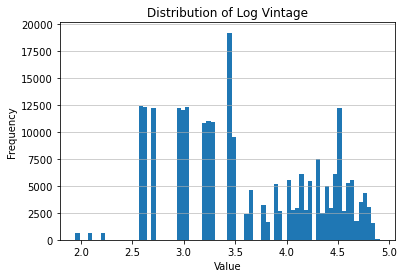

In [19]:
n, bins, patches = plt.hist(x=ccpH['Vintage'], bins='auto')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Log Vintage')

In [20]:
print(ccpH['Gender'].value_counts())
print(ccpH['Region_Code'].value_counts())
print(ccpH['Occupation'].value_counts())
print(ccpH['Channel_Code'].value_counts())
print(ccpH['Credit_Product'].value_counts())
print(ccpH['Is_Active'].value_counts())
print(ccpH['Is_Lead'].value_counts())

Male      134197
Female    111528
Name: Gender, dtype: int64
RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64
Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64
X1    103718
X3     68712
X2     67726
X4      5569
Name: Channel_Code, dtype: int64
No     144357
Yes     72043
Name: Credit_Product, dtype: int64
No     150290
Yes     95435
Name: Is_Active, dtype: int64
0    187437
1     58288
Name: Is_Lead, dtype: int

There is some imbalance. There are some underrepresented regions, occupations, and channel codes.

We encountered missingness in Credit_Product. For over 10% of historical records, we did not have data on whether the customer has a credit product with us. In these cases, we simply created a new category for that feature, corresponding to customers for whom we did not know whether they have a credit product. We also encountered imbalance. Essentially, there were many more customers who were not leads than those who were. Without adjustment, this imbalance could lead to our model making weaker predictions on customers who are leads. To remedy this, we implemented SMOTE, a technique that allowed us to synthesize new records on customers who are leads, addressing the imbalance.

The model we fit takes in these customer details and attempts to predict whether the customer is a lead. A random 20% of the historical data that the model had not seen before was used to test it. The model was given the customer details, and used them to make predictions on whether the customers were leads. We compared the results to our historical record of which of the customers were leads in order to assess the model's prediction accuracy.

In [21]:
print(X_test.shape)
print("The accuracy of the model is {}".format(ccpH_xgb_sm.score(X_test,y_test)))

(49145, 53)
The accuracy of the model is 0.8575033065418659


Out of the 49 thousand predictions made, our model got 86% of them correct. 

In [22]:
1-sum(y_test['Is_Lead'])/49145

0.7641876080984841

On the other hand, simply guessing "not lead" (the most likely option) for each customer would result in an accuracy of 76%.

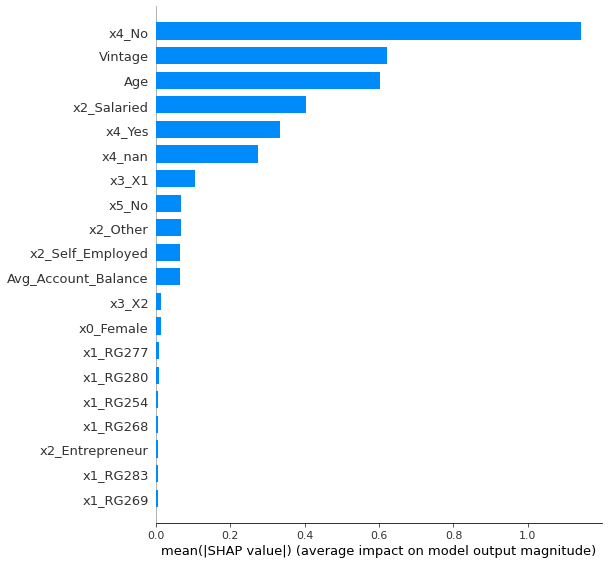

In [23]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(ccpH_xgb_sm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, feature_names=list(X_train.columns),plot_type='bar')

The most impactful features on the prediction are whether or not the customer has an active credit product with us, their vintage, their age, and whether or not they are salaried. 

In [24]:
ccpP = pd.read_csv("credit_card_propensity_production.csv")
ccpP.fillna('Missing');
ccpP['Vintage']=np.log(ccpP['Vintage'])
X_new_cat = enc.transform(ccpP[['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']]).toarray()
X_new_real = scaler.transform(ccpP[['Age','Vintage','Avg_Account_Balance']])
X_new = pd.DataFrame(np.concatenate((X_new_cat, X_new_real), axis=1))
X_new.columns = X_train.columns
y_new_preds = ccpH_xgb_sm.predict(X_new)
print(ccpP.shape)
print(sum(y_new_preds))

(105312, 10)
20570


Out of the 105312 new customers, the model recommends that the CSR reach out to 20570 of them. The full list of who to reach out to is given in the following table:

In [25]:
reachOut = pd.DataFrame(y_new_preds)
reachOut.columns = ['Reach_Out']
ccpP_new = pd.concat([ccpP, reachOut], axis=1)
ccpP_new.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Reach_Out
0,VBENBARO,Male,29,RG254,Other,X1,3.218876,Yes,742366,No,0
1,CCMEWNKY,Male,43,RG268,Other,X2,3.891820,NaN,925537,No,1
2,VK3KGA9M,Male,31,RG270,Salaried,X1,2.639057,No,215949,No,0
3,TT8RPZVC,Male,29,RG272,Other,X1,3.496508,No,868070,No,0
4,SHQZEYTZ,Female,29,RG270,Other,X1,2.944439,No,657087,No,0


Since we have already tested our model against historical data, in order for this pilot to prove my model’s efficacy, the next step is for us to design an A/B test with a sample of the bank’s customers. I would do this via the following steps:

Step 1: Determine sample size.
I would start off by discussing with the head of the bank and any relevant employees to come up with a sample size that achieves statistical significance. From here, we can also get a rough estimate of the timeline of this pilot as we now know how many people we will need to include in this test. Note that blocking may need to be done at this stage to ensure that enough customers in this sample are actually deemed as a lead by my model. To get around this, we can pick our sample strictly from the population which my model deems as a lead. 

Step 2: Begin testing.
Once the sample size is determined, the testing process will be quite straightforward. Each customer part of the sample will be assigned to set A or set B. Customers in Set A will only be contacted by a CSR if my model predicts that they are interested in a credit product. Customers in Set B will follow the status quo procedures wherein a CSR will reach out based on existing business rules. As customers are reached out to, CSR agents will record whether the customer is truly a lead. 

Step 3: Review.
Once all the customers in the sample size has been tested on, I would then analyze the data to determine the percentage of customers who were wrongly marked as a lead in Set A (false positives) and compare that with the percentage of customers contacted by CSR who were not leads in Set B. As long as % imprecision Set A < % imprecision Set B, I will be able to make a case for the efficacy of my model.

One thing that is important to note is the guideline that "if your model predicts a customer is interested in a credit product, the CSR will reach out and try to sell one to them. If your model predicts a customer is not interested, then no action will be taken on that customer". This methodology only produces a % of correct lead determination (i.e. precision) rather than an % of accuracy overall. For example, we don’t know if the model decided that a customer is uninterested while they really were (i.e. no record of false negatives). Similarly, we won’t be able to know if a CSR agent decided to not reach out to a customer who was a lead. Arguably, recall would be a better metric than precision since the cost of a false negative is higher (lost revenue) compared to the cost of a false positive (customer declines credit product). In order to determine recall as well, we would need to collect the rest of the data in the confusion matrix. If we wanted to establish a confusion matrix, we would need to first record both the model and the CSR’s decision, then reach out to every customer to record their interest. While this could work given a small sample, it can quickly become an expensive and time consuming decision as we scale the sample size. Thus, proving the efficacy of my model based on showcasing a positive difference in precision is the method I would propose. 